In [26]:
#import libraries
# import librosa
import h5py
import os
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
# import librosa.display
import numpy as np
from scipy.signal import argrelmax, argrelmin, firwin, convolve,argrelextrema
MINIMUM_PULSE_CYCLE = 0.5
MAXIMUM_PULSE_CYCLE = 1.2
PPG_SYSTOLIC_PEAK_DETECTION_THRESHOLD_COEFFICIENT = 0.5
PPG_SAMPLE_RATE = 125
PPG_FIR_FILTER_TAP_NUM = 200
PPG_FILTER_CUTOFF = [0.5, 5.0]
PPG_SYSTOLIC_PEAK_DETECTION_THRESHOLD_COEFFICIENT = 0.5

In [31]:
#load ppg windows
#win='D:/Implementation/NeuralnetworkBPestimation/data/Rec_mimic/3001203/3001203_0010.h5'
win='D:/Implementation/NeuralnetworkBPestimation/data/win1.h5'
# win=r'F:\Projets\Gaby project\NeuralnetworkBPestimation\win2_ppg.h5'
with h5py.File(win, "r") as f:
    for line in f:
        print(line)
        print(f[line])

label
<HDF5 dataset "label": shape (310204, 2), type "<i4">
ppg
<HDF5 dataset "ppg": shape (310204, 625), type "<f4">
subject_idx
<HDF5 dataset "subject_idx": shape (310204, 1), type "<i4">


## Display a ppg window

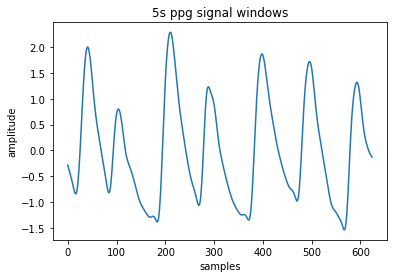

In [32]:
with h5py.File(win,'r') as db:
    ppg = db['ppg']
    #plt.plot(ppg[12,:])
    ppg_data=ppg[879,:]
    plt.plot(ppg_data)
    #plt.plot(ppg[1000,:])
    #plt.plot(ppg[1,:])
    plt.xlabel('samples')
    plt.ylabel('amplitude')
    plt.title('5s ppg signal windows')

### Row extraction

In [33]:
#Extract a row from the ppg along with label corresponding to the row
def Extract_row_win(win,row_nbr):
    with h5py.File(win,'r') as db:
        ppg= db['ppg']
        abp=db['label']
        row= ppg[row_nbr,:]
        row_label=abp[row_nbr,:]
        SBP=row_label[0]
        DBP=row_label[1]
        return row, SBP, DBP

## Find and extrema

In [34]:
def find_extrema(signal):
    signal = np.array(signal)
    extrema_index = np.sort(np.unique(np.concatenate((argrelmax(signal)[0], argrelmin(signal)[0]))))
    extrema = signal[extrema_index]
    return zip(extrema_index.tolist(), extrema.tolist())

## Extract a waveform

In [41]:
def extract_ppg_single_waveform(signal, sample_rate=PPG_SAMPLE_RATE):
    signal_ppg=signal[0]
    SBP=signal[1]
    DBP=signal[2]
    threshold = (max(signal_ppg) - min(signal_ppg)) * PPG_SYSTOLIC_PEAK_DETECTION_THRESHOLD_COEFFICIENT
    single_waveforms = []
    single_waveforms = []
    last_extremum_index = None
    last_extremum = None
    last_single_waveform_start_index = None
    for extremum_index, extremum in find_extrema(signal=signal_ppg):
        if last_extremum is not None and np.array(extremum )- np.array(last_extremum) > threshold:
            if last_single_waveform_start_index is not None:
                single_waveform = signal_ppg[last_single_waveform_start_index:last_extremum_index]
                if len(single_waveform)<=140:
                    single_waveforms.append(single_waveform)
            last_single_waveform_start_index = last_extremum_index
        last_extremum_index = extremum_index
        last_extremum = extremum

    single_waveforms_next=single_waveforms[1:]
    single_waveforms=single_waveforms[:-1]
    return single_waveforms,SBP,DBP,single_waveforms_next

## Extract 20 PPG features

In [51]:
def extract_ppg20(wave,next_wave,sample_rate=125):
    maxima_index = np.squeeze(argrelmax(wave))
    if len(maxima_index.shape)>0:
        maxima_index=maxima_index[0]

    next_maxima_index = np.squeeze(argrelmax(next_wave))
    if len(next_maxima_index.shape)>0:
        next_maxima_index=next_maxima_index[0]

    cp=(wave.shape[0]-maxima_index)+next_maxima_index
    cp=cp/PPG_SAMPLE_RATE
    #print(x)
    minima_index = np.squeeze(argrelextrema(wave,np.less_equal))
    #print(minima_index)
    sys_min_index=minima_index[0]
    dias_min_index=minima_index[-1]

    features_dict={}
    features_dict["CP"]=cp
    # cp_points=[maxima_index,next_maxima_index+wave.shape[0]],[wave[maxima_index],wave[maxima_index]]




    features_points=[],[]
    targets=[0, 10, 25, 33, 50, 66, 75]




    #2. Diastolic features
    dias_ampli=wave[maxima_index]-wave[dias_min_index]
    dias_features=["DT","DW10","DW25","DW33","DW50","DW66","DW75"]
    target_idx=0
    for i in reversed(range(maxima_index,dias_min_index+1)):
        ampli=wave[i]-wave[dias_min_index]
        if ampli>=dias_ampli*targets[target_idx]/100:
            # features_points[0].append(i)
            # features_points[1].append(wave[i])
            dt=(i-maxima_index)/PPG_SAMPLE_RATE
            features_dict[dias_features[target_idx]]=dt
            target_idx+=1
            if target_idx>=len(targets):break

    #1. Systolic features
    sys_ampli=wave[maxima_index]-wave[sys_min_index]
    sys_features=["SUT", "SW10", "SW25", "SW33", "SW50", "SW66", "SW755"]
    target_idx=0
    for i in range(sys_min_index,maxima_index):
        ampli=wave[i]-wave[sys_min_index]
        if ampli >=sys_ampli*targets[target_idx]/100:
            features_points[0].append(i)
            features_points[1].append(wave[i])
            dt=(maxima_index-i)/PPG_SAMPLE_RATE
            if target_idx==0:
                features_dict[sys_features[target_idx]]=dt
            else:
                try:
                    features_dict[f"SW_DW_ADD{targets[target_idx]}"]= dt + features_dict[dias_features[target_idx]]
                #print()
                    features_dict[f"SW_DW_DIV_{targets[target_idx]}"]=  features_dict[dias_features[target_idx]]/dt 
                except:
                    print(maxima_index,minima_index)
                    plt.plot(wave)
                    return
            
            target_idx+=1
            if target_idx>=len(targets):break
    features_values=list(features_dict.values())
    # plt.plot(wave)
    # plt.plot(list(range(wave.shape[0],wave.shape[0]+next_wave.shape[0])),next_wave)
    # plt.scatter(features_points[0],features_points[1],color="red")
    # plt.plot(cp_points[0],cp_points[1])
    print(features_dict)
    return features_values
    
    



 

## RUN ONLY ONCE!!!!

{'CP': 0.744, 'DT': 0.528, 'DW10': 0.408, 'DW25': 0.304, 'DW33': 0.256, 'DW50': 0.184, 'DW66': 0.12, 'DW75': 0.088, 'SUT': 0.224, 'SW_DW_ADD10': 0.576, 'SW_DW_DIV_10': 2.4285714285714284, 'SW_DW_ADD25': 0.44799999999999995, 'SW_DW_DIV_25': 2.111111111111111, 'SW_DW_ADD33': 0.392, 'SW_DW_DIV_33': 1.8823529411764706, 'SW_DW_ADD50': 0.296, 'SW_DW_DIV_50': 1.6428571428571428, 'SW_DW_ADD66': 0.216, 'SW_DW_DIV_66': 1.25, 'SW_DW_ADD75': 0.16799999999999998, 'SW_DW_DIV_75': 1.0999999999999999}


FileNotFoundError: [Errno 2] No such file or directory: 'D:/Implementation/NeuralnetworkBPestimation/data/Features_ppg_20/subject_10_features.csv'

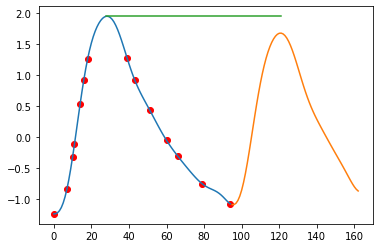

In [53]:
"""Extract features from the 15000 first sample
"""
import random
TAILLE_MAX=3475840
choices=random.choices(list(range(TAILLE_MAX)),k=15000)
for i in choices:
    row=Extract_row_win(win,i) #extract one window of ppg signal
    waveforms=extract_ppg_single_waveform(row) #extract the single waveforms from the window
    a=str(i)
    features=[]
    if len(waveforms[0])>=1:
        for j in range(len(waveforms[0])):
        #plt.plot(waveforms[0][i])
            feature=extract_ppg20(waveforms[0][j],waveforms[3][j]) # extract five ppg features from each waveform

           # while len(features<=3):
            features.append(feature)
            feat_np=np.array(features) #transform the list into a numpy array
        #print(feat_np)
        #print(i)
        #print(len(waveforms[0]))

        feature=np.concatenate([feat_np,waveforms[1]*np.ones((len(waveforms[0]),1)),waveforms[2]*np.ones((len(waveforms[0]),1))],axis=1)
        #print(feature)
        np.savetxt(r'D:/Implementation/NeuralnetworkBPestimation/data/Features_ppg_20/subject_'+a+'_features.csv',feature)
    else:
        continue



### Split the folder in train test and val set for ANN ratio:70 15 15

In [ ]:
import os
import shutil
from sklearn.model_selection import train_test_split
directory="data/Features_ppg_20"
files = [os.path.join(directory,f) for f in os.listdir(directory)]
train,test= train_test_split(files,test_size=0.3)
test,val=train_test_split(test, test_size=0.5)


data_dir=os.path.join("data","ppg_20_features_data")
train_dir=os.path.join(data_dir,"train")
test_dir=os.path.join(data_dir,"test")
val_dir=os.path.join(data_dir,"val")
for (files, directory) in zip([train,test,val],[train_dir,test_dir,val_dir]):
    #print(directory)
    if not os.path.exists(directory):
        os.makedirs(directory)
    for file in files:
            
        shutil.move(file,os.path.join(directory,os.path.basename((file))))

In [ ]:
row=Extract_row_win(win,row_nbr=879)
#print(row[0].shape)
waveforms=extract_ppg_single_waveform(row)
#print(len(waveforms[0]))


for i in range(len(waveforms[0])):
    a=str(i)
    #plt.plot(waveforms[0][i])
    
feature=extract_ppg20(waveforms[0][1])
print(feature)

    



In [ ]:
 #print(np.array(waveforms[0]))
 maxima_index = argrelmax(waveforms[0][1])
 #print(maxima_index)
 x = waveforms[0][1][maxima_index][0]
 #print(x)
 minima_index = argrelextrema((waveforms[0][1]),np.less_equal)
 print(minima_index)
